[View in Colaboratory](https://colab.research.google.com/github/AlbertZheng/deep-learning-lab/blob/master/tensorlayer/notebooks/tutorial_cifar10_tfrecord.ipynb)

## 安装依赖packages

In [1]:
!pip install "tensorlayer>=1.10"
!pip list|grep tensor


    100% |████████████████████████████████| 317kB 5.7MB/s 
    100% |████████████████████████████████| 3.3MB 8.6MB/s 
    100% |████████████████████████████████| 51kB 13.8MB/s 
    100% |████████████████████████████████| 31.2MB 1.5MB/s 
    100% |████████████████████████████████| 5.8MB 4.1MB/s 
    100% |████████████████████████████████| 25.3MB 2.1MB/s 
    100% |████████████████████████████████| 12.6MB 875kB/s 
    100% |████████████████████████████████| 92kB 25.4MB/s 
    100% |████████████████████████████████| 665kB 18.7MB/s 
    100% |████████████████████████████████| 952kB 18.8MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
scikit-image 0.14.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: tqdm 4.26.0
    Uninstalling tqdm-4.26.0:
      Successfully uninstal

## 检测GPU

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import *

tf.logging.set_verbosity(tf.logging.DEBUG)
tl.logging.set_verbosity(tl.logging.DEBUG)


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('*** GPU device not found ***')
print('### Found GPU at: {} ###'.format(device_name))

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True


### Found GPU at: /device:GPU:0 ###


## Download cifar10 data, and convert to TFRecord format

[TL] Load or Download cifar10 > data/cifar10
[TL] Downloading cifar-10-python.tar.gz...



100% (20813 of 20813) |##################| Elapsed Time: 0:00:54 ETA:  00:00:00

[TL] Succesfully downloaded cifar-10-python.tar.gz 170498071 bytes.
[TL] Trying to extract tar file
[TL] ... Success!
X_train.shape (50000, 32, 32, 3)
y_train.shape (50000,)
X_test.shape (10000, 32, 32, 3)
y_test.shape (10000,)
X float32   y int32
Converting data into train.cifar10 ...
Current directory: /content 


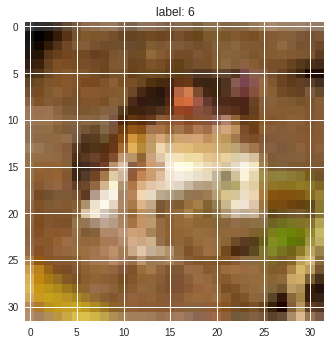

Converting data into test.cifar10 ...
Current directory: /content 


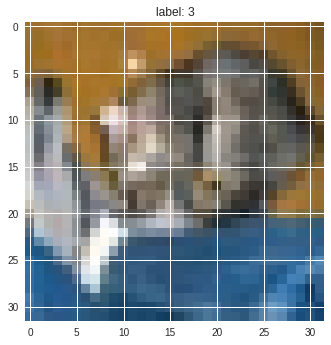

In [3]:
# Download data, and convert to TFRecord format
X_train, y_train, X_test, y_test = tl.files.load_cifar10_dataset(shape=(-1, 32, 32, 3), plotable=False)

print('X_train.shape', X_train.shape)  # (50000, 32, 32, 3)
print('y_train.shape', y_train.shape)  # (50000,)
print('X_test.shape', X_test.shape)  # (10000, 32, 32, 3)
print('y_test.shape', y_test.shape)  # (10000,)
print('X %s   y %s' % (X_test.dtype, y_test.dtype))  # X float32   y int32


def data_to_tfrecord(images, labels, filename):
    """Save data into TFRecord."""
    if os.path.isfile(filename):
        print("%s exists" % filename)
        return
    
    print("Converting data into %s ..." % filename)
    print("Current directory: %s " % os.getcwd())
    
    writer = tf.python_io.TFRecordWriter(filename)
    for index, img in enumerate(images):
        label = int(labels[index])
        img_raw = img.tobytes()

        # Visualize a image
        if index == 0:
            #tl.visualize.images2d([img], second=1, saveable=False, name='label: ' + str(label), dtype=np.uint8, fig_idx=1236)
            tl.visualize.frame(np.asarray(img, dtype=np.uint8), second=1, saveable=False, name='label: ' + str(label), fig_idx=1236)

        # Convert the bytes back to image as follow:
        # image = Image.frombytes('RGB', (32, 32), img_raw)
        # image = np.fromstring(img_raw, np.float32)
        # image = image.reshape([32, 32, 3])
        # tl.visualize.frame(np.asarray(image, dtype=np.uint8), second=1, saveable=False, name='frame', fig_idx=1236)
        
        example = tf.train.Example(
            features=tf.train.Features(
                feature={
                    "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
                    'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
                }
            )
        )
        writer.write(example.SerializeToString())  # Serialize To String
    writer.close()

    
# Save data into TFRecord files
data_to_tfrecord(images=X_train, labels=y_train, filename="train.cifar10")
data_to_tfrecord(images=X_test, labels=y_test, filename="test.cifar10")


## Build the model, and run it, test it

In [0]:
def read_and_decode(filename, is_train=None):
    """Return tensor to read from TFRecord."""
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example, features={
            'label': tf.FixedLenFeature([], tf.int64),
            'img_raw': tf.FixedLenFeature([], tf.string),
        }
    )
    # You can do more image distortion here for training data
    img = tf.decode_raw(features['img_raw'], tf.float32)
    img = tf.reshape(img, [32, 32, 3])
    # img = tf.cast(img, tf.float32) #* (1. / 255) - 0.5
    if is_train == True:
        # 1. Randomly crop a [height, width] section of the image.
        img = tf.random_crop(img, [24, 24, 3])

        # 2. Randomly flip the image horizontally.
        img = tf.image.random_flip_left_right(img)

        # 3. Randomly change brightness.
        img = tf.image.random_brightness(img, max_delta=63)

        # 4. Randomly change contrast.
        img = tf.image.random_contrast(img, lower=0.2, upper=1.8)

        # 5. Subtract off the mean and divide by the variance of the pixels.
        img = tf.image.per_image_standardization(img)

    elif is_train == False:
        # 1. Crop the central [height, width] of the image.
        img = tf.image.resize_image_with_crop_or_pad(img, 24, 24)

        # 2. Subtract off the mean and divide by the variance of the pixels.
        img = tf.image.per_image_standardization(img)

    elif is_train == None:
        img = img

    label = tf.cast(features['label'], tf.int32)
    return img, label


batch_size = 128
model_file_name = "./model_cifar10_advanced.ckpt"
resume = False  # load model, resume from previous checkpoint?

with tf.device('/cpu:0'):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    # prepare data in cpu
    x_train_, y_train_ = read_and_decode("train.cifar10", True)
    x_test_, y_test_ = read_and_decode("test.cifar10", False)

    x_train_batch, y_train_batch = tf.train.shuffle_batch(
        [x_train_, y_train_], batch_size=batch_size, capacity=2000, min_after_dequeue=1000, num_threads=32
    )  # set the number of threads here
    # for testing, uses batch instead of shuffle_batch
    x_test_batch, y_test_batch = tf.train.batch(
        [x_test_, y_test_], batch_size=batch_size, capacity=50000, num_threads=32
    )
    

    def model(x_crop, y_, reuse):
        """For more simplified CNN APIs, check tensorlayer.org."""
        W_init = tf.truncated_normal_initializer(stddev=5e-2)
        W_init2 = tf.truncated_normal_initializer(stddev=0.04)
        b_init2 = tf.constant_initializer(value=0.1)
        with tf.variable_scope("model", reuse=reuse):
            net = InputLayer(x_crop, name='input')
            net = Conv2d(net, 64, (5, 5), (1, 1), act=tf.nn.relu, padding='SAME', W_init=W_init, name='cnn1')
            net = MaxPool2d(net, (3, 3), (2, 2), padding='SAME', name='pool1')
            net = LocalResponseNormLayer(net, depth_radius=4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

            net = Conv2d(net, 64, (5, 5), (1, 1), act=tf.nn.relu, padding='SAME', W_init=W_init, name='cnn2')
            net = LocalResponseNormLayer(net, depth_radius=4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
            net = MaxPool2d(net, (3, 3), (2, 2), padding='SAME', name='pool2')

            net = FlattenLayer(net, name='flatten')
            net = DenseLayer(net, 384, act=tf.nn.relu, W_init=W_init2, b_init=b_init2, name='d1relu')
            net = DenseLayer(net, 192, act=tf.nn.relu, W_init=W_init2, b_init=b_init2, name='d2relu')
            net = DenseLayer(net, n_units=10, act=None, W_init=W_init2, name='output')
            y = net.outputs

            ce = tl.cost.cross_entropy(y, y_, name='cost')
            # L2 for the MLP, without this, the accuracy will be reduced by 15%.
            L2 = 0
            for p in tl.layers.get_variables_with_name('relu/W', True, True):
                L2 += tf.contrib.layers.l2_regularizer(0.004)(p)
            cost = ce + L2

            # correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(y), 1), y_)
            correct_prediction = tf.equal(tf.cast(tf.argmax(y, 1), tf.int32), y_)
            acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            return net, cost, acc

        
    with tf.device('/gpu:0'):  # <-- remove it if you don't have GPU
        # using local response normalization
        network, cost, acc, = model(x_train_batch, y_train_batch, False)
        _, cost_test, acc_test = model(x_test_batch, y_test_batch, True)
        # you may want to try batch normalization
        # network, cost, acc, = model_batch_norm(x_train_batch, y_train_batch, None, is_train=True)
        # _, cost_test, acc_test = model_batch_norm(x_test_batch, y_test_batch, True, is_train=False)

    # train
    n_epoch = 50000
    learning_rate = 0.0001
    print_freq = 1
    n_step_epoch = int(len(y_train) / batch_size)
    n_step = n_epoch * n_step_epoch

    with tf.device('/gpu:0'):  # <-- remove it if you don't have GPU
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    tl.layers.initialize_global_variables(sess)
    if resume:
        print("Load existing model " + "!" * 10)
        saver = tf.train.Saver()
        saver.restore(sess, model_file_name)

    network.print_params(False)
    network.print_layers()

    print('   learning_rate: %f' % learning_rate)
    print('   batch_size: %d' % batch_size)
    print('   n_epoch: %d, step in an epoch: %d, total n_step: %d' % (n_epoch, n_step_epoch, n_step))

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    step = 0
    for epoch in range(n_epoch):
        start_time = time.time()
        train_loss, train_acc, n_batch = 0, 0, 0
        for s in range(n_step_epoch):
            # You can also use placeholder to feed_dict in data after using
            # val, l = sess.run([x_train_batch, y_train_batch])
            # tl.visualize.images2d(val, second=3, saveable=False, name='batch', dtype=np.uint8, fig_idx=2020121)
            # err, ac, _ = sess.run([cost, acc, train_op], feed_dict={x_crop: val, y_: l})
            err, ac, _ = sess.run([cost, acc, train_op])
            step += 1
            train_loss += err
            train_acc += ac
            n_batch += 1

        if epoch + 1 == 1 or (epoch + 1) % print_freq == 0:
            print(
                "Epoch %d : Step %d-%d of %d took %fs" %
                (epoch, step, step + n_step_epoch, n_step, time.time() - start_time)
            )
            print("   train loss: %f" % (train_loss / n_batch))
            print("   train acc: %f" % (train_acc / n_batch))

            test_loss, test_acc, n_batch = 0, 0, 0
            for _ in range(int(len(y_test) / batch_size)):
                err, ac = sess.run([cost_test, acc_test])
                test_loss += err
                test_acc += ac
                n_batch += 1
            print("   test loss: %f" % (test_loss / n_batch))
            print("   test acc: %f" % (test_acc / n_batch))

        if (epoch + 1) % (print_freq * 50) == 0:
            print("Save model " + "!" * 10)
            saver = tf.train.Saver()
            save_path = saver.save(sess, model_file_name)
            # you can also save model into npz
            tl.files.save_npz(network.all_params, name='model.npz', sess=sess)
            # and restore it as follow:
            # tl.files.load_and_assign_npz(sess=sess, name='model.npz', network=network)

    coord.request_stop()
    coord.join(threads)
    sess.close()


[TL] InputLayer  model/input: (128, 24, 24, 3)
[TL] Conv2d model/cnn1: n_filter: 64 filter_size: (5, 5) strides: (1, 1) pad: SAME act: relu
[TL] MaxPool2d model/pool1: filter_size: (3, 3) strides: (2, 2) padding: SAME
[TL] LocalResponseNormLayer model/norm1: depth_radius: 4, bias: 1.0, alpha: 0.00011111111111111112, beta: 0.75
[TL] Conv2d model/cnn2: n_filter: 64 filter_size: (5, 5) strides: (1, 1) pad: SAME act: relu
[TL] LocalResponseNormLayer model/norm2: depth_radius: 4, bias: 1.0, alpha: 0.00011111111111111112, beta: 0.75
[TL] MaxPool2d model/pool2: filter_size: (3, 3) strides: (2, 2) padding: SAME
[TL] FlattenLayer model/flatten: 2304
[TL] DenseLayer  model/d1relu: 384 relu
[TL] DenseLayer  model/d2relu: 192 relu
[TL] DenseLayer  model/output: 10 No Activation
[TL]   [*] geting variables with relu/W
[TL]   got   0: model/d1relu/W:0   (2304, 384)
[TL]   got   1: model/d2relu/W:0   (384, 192)
[TL] InputLayer  model/input: (128, 24, 24, 3)
[TL] Conv2d model/cnn1: n_filter: 64 filter